In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_selection import RFE

from xgboost import *
from hyperopt import hp

from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline 
from datetime import datetime


### load Layoff_final_1 for plot purpose

In [11]:
df = pd.read_csv('Layoffs_Final_3.csv')
df_raw =  pd.read_csv('Layoffs_Final_1.csv')


In [4]:

df = df.drop(['Company', 'City', 'Effective Date', 'Closure/Layoff','Temporary/Permanent','Union','Region','County'], axis=1)

df['WARN Received Date'] = pd.to_datetime(df['WARN Received Date'])
df['by_month'] = df['WARN Received Date'].dt.strftime("%Y-%m")
# df['Day'] = df['WARN Received Date'].dt.day
# df['Month'] = df['WARN Received Date'].dt.month
# df['Year'] = df['WARN Received Date'].dt.year
df['Price Volatility'] = df['High'] - df['Low']
#df['by_month'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
#df['Effective Date'] = pd.to_datetime(df['Effective Date'])
df['Number of Workers'] = pd.to_numeric(df['Number of Workers'], errors='coerce')
df.dropna(subset=['Number of Workers'], inplace=True)
# df['year'] = df['WARN Received Date'].dt.year
# df['month'] = df['WARN Received Date'].dt.month


### <font color='orange'>Layoff case number for each class</font>

In [5]:
df['layoff_category_by_num'].value_counts().to_frame()

,layoff_category_by_num
1,2347
2,1987
3,549


### <font color='orange'>Layoff case number for each class</font>

In [6]:
df['layoff_category_by_log'].value_counts()

3    1767
2    1701
1    1415
Name: layoff_category_by_log, dtype: int64

In [8]:
df.dropna(subset=['layoff_category_by_log'],inplace=True)


Text(0.5, 0, 'Nuumber of layoffs per case report')

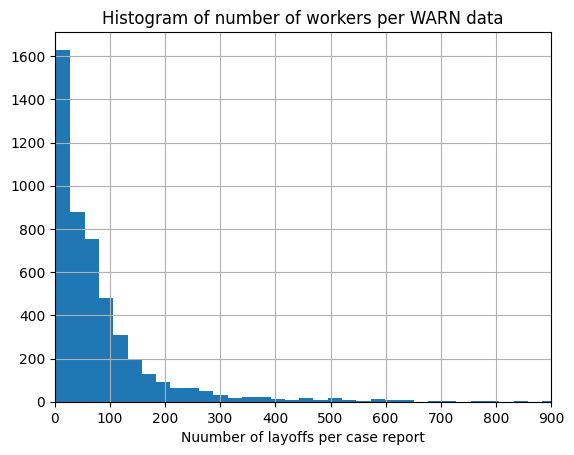

In [7]:
df['Number of Workers'].hist(bins=200)
plt.xlim([0,900])
plt.title('Histogram of number of workers per WARN data')
plt.xlabel('Nuumber of layoffs per case report')

In [12]:
df_raw = df_raw.drop(['Company', 'City', 'Effective Date', 'Closure/Layoff','Temporary/Permanent','Union','Region','County'], axis=1)
df_raw['WARN Received Date'] = pd.to_datetime(df_raw['WARN Received Date'])
df_raw['by_month'] = df_raw['WARN Received Date'].dt.strftime("%Y-%m")
df_raw['Number of Workers'] = pd.to_numeric(df_raw['Number of Workers'], errors='coerce')
df_raw['total_layoff'] = df_raw.groupby(['by_month'])['Number of Workers'].transform(sum)
df1_raw = df_raw.drop_duplicates(subset=['by_month','total_layoff'], keep='first')
#df1.by_month = df1.by_month.apply(lambda x:x.strftime('%Y-%m'))
df1_raw.by_month = pd.to_datetime(df1_raw.by_month)
df1_raw.sort_values(by='by_month', inplace=True)
df1_raw.dropna(subset=['Number of Workers'],inplace=True)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(2017-03-01 00:00:00, 140000, 'COVID pandemic')

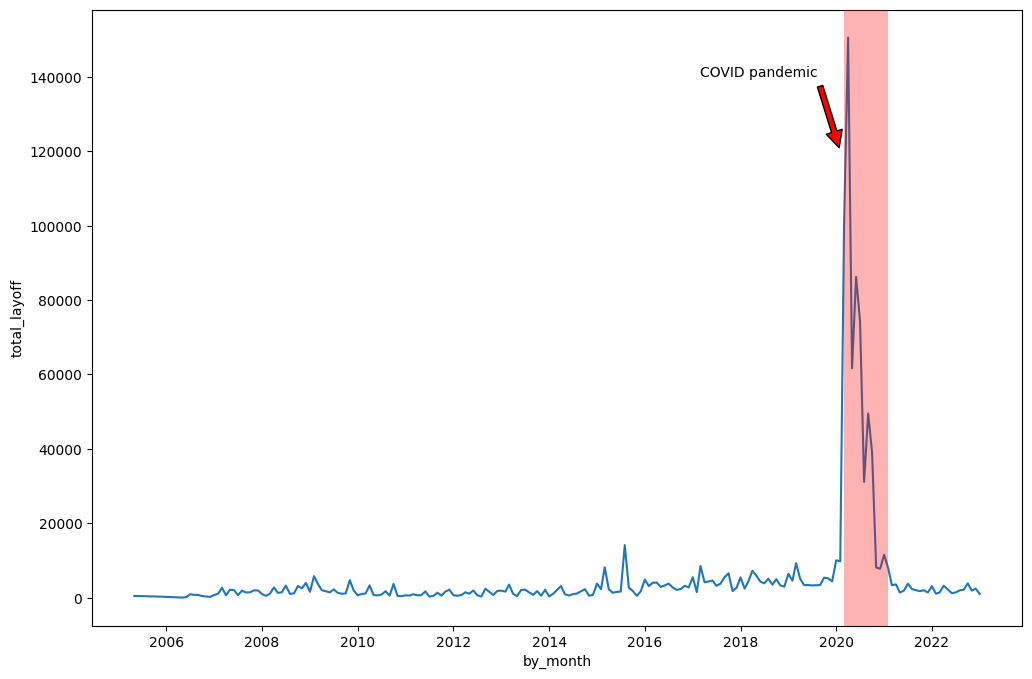

In [13]:
plt.figure(figsize=(12,8))
sns.lineplot(x='by_month',y='total_layoff', data=df1_raw)
plt.axvspan(datetime.strptime("2020-03", '%Y-%m'), datetime.strptime("2021-02", '%Y-%m'), facecolor='r', alpha=0.3,zorder=3)
plt.annotate('COVID pandemic', (datetime.strptime("2020-02", '%Y-%m'),120000), (datetime.strptime("2017-03", '%Y-%m'),140000),arrowprops=dict(facecolor='red', shrink=0.05))
#sns.lineplot(x='by_month',y='actual_hires_sm', data=df1)

In [9]:
df['total_layoff'] = df.groupby(['by_month'])['Number of Workers'].transform(sum)
df1 = df.drop_duplicates(subset=['by_month','total_layoff'], keep='first')
#df1.by_month = df1.by_month.apply(lambda x:x.strftime('%Y-%m'))
df1.by_month = pd.to_datetime(df1.by_month)
df1.sort_values(by='by_month', inplace=True)
df1.dropna(subset=['Number of Workers'],inplace=True)

df1['hire_cumsum'] = df1['hires_sm'].diff().cumsum()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


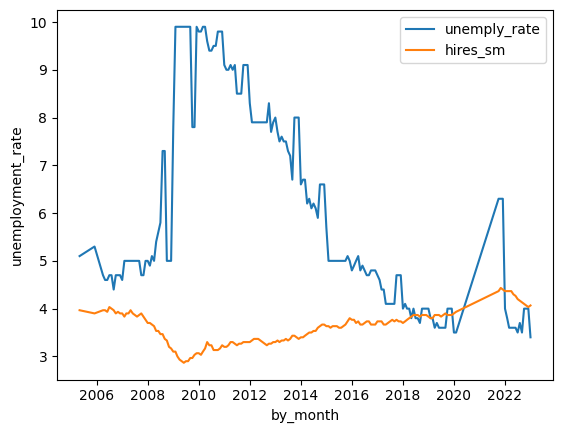

In [10]:
sns.lineplot(x='by_month',y='unemployment_rate', data=df1, label='unemply_rate')
#sns.lineplot(x='by_month',y='actual_hire', data=df1, label='actual_hire')
sns.lineplot(x='by_month',y='hires_sm', data=df1, label='hires_sm')
plt.legend()

In [15]:
df_col = [#'State', 'Company', 'City', 'Number of Workers', 'WARN Received Date','Effective Date', 'Closure/Layoff', 'Temporary/Permanent', 'Union','by_month', 'Date','Region', 'County',
       'Industry', 'Open', 'High', 'Low', 'Close',
       'Volume', 'CPI', 'PPI', 'GDP', 'unemployment_rate', 'job_nonfam',
       'job_IT', 'job_service', 'job_retail', 'job_education_health',
       'fed_rate', 'PPI_chg', 'PPI_CPI', 
       'Hire_quite_jolts', 'Job_seekers_ratio', 'hires_sm', 'quits_sm',
       'layoffs_sm', 'actual_hire',
       'layoff_category_by_log', 'layoff_category_by_num' ]
df1 = df[df_col].copy()

### <font color='orange'>Use Label_encoder to convert Industry column</font>

In [19]:
le = preprocessing.LabelEncoder()
df1['Industry']=le.fit_transform(df1['Industry'])
df1['Industry'] = df1['Industry'].astype('category')


### <font color='orange'>y is layoff class defined by absoulte pre-set number</font>

In [20]:
X = df1.iloc[:,:-2]
y = df1.iloc[:,-1]

### <font color='orange'>Split train and test and keep sampling size for each class</font>

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=77, stratify=df['layoff_category_by_num'])

model_name = []
acc = []
precision = []
f1 = []
recall = []


acc_t = []
precision_t = []
f1_t = []
recall_t = []

### Use RFE for RF

In [22]:
# define the method
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
# fit the model
rfe.fit(X, y)



RFE(estimator=RandomForestClassifier(), n_features_to_select=10)

In [23]:
rfe.get_feature_names_out()

array(['Open', 'High', 'Low', 'Close', 'Volume', 'CPI', 'fed_rate',
       'PPI_CPI', 'Job_seekers_ratio', 'actual_hire'], dtype=object)

In [24]:
rf_sector = []
rf_model = []
rf_best_param = []
rf_acc = []
rf_fi = []


randomforestCLF = RandomForestClassifier(criterion = 'gini' , n_jobs = -1)

parameters_rf = {'n_estimators':[10 , 100 , 250, 500, 600,700,1000 ],
                 'max_depth' : [ None , 4 , 8  , 10 , 12] , 
                 'max_features' : ['sqrt' , 'log2'] , 
                 'max_leaf_nodes' : [2 , 4 , 8 , 10] ,
                 'max_samples' : [50 , 100 , 150,300]}

'''cross validation'''
rf_rand_cv = RandomizedSearchCV(randomforestCLF , parameters_rf , cv = 5 ,scoring='accuracy', n_jobs = -1 ,error_score='raise')
rf_rand_cv.fit(X_train[rfe.get_feature_names_out()], y_train)

rf_best_param.append(rf_rand_cv.best_params_)

randomforestCLF = RandomForestClassifier(n_estimators = rf_rand_cv.best_params_['n_estimators'] , 
                                                                max_depth = rf_rand_cv.best_params_['max_depth'], 
                                                                max_features = rf_rand_cv.best_params_['max_features'],
                                                                max_leaf_nodes = rf_rand_cv.best_params_['max_leaf_nodes'],
                                                                max_samples = rf_rand_cv.best_params_['max_samples'],
                                                                n_jobs = -1)
randomforestCLF.fit(X_train[rfe.get_feature_names_out()], y_train)


RandomForestClassifier(max_depth=4, max_leaf_nodes=10, max_samples=300,
                       n_estimators=500, n_jobs=-1)

In [25]:
rf_rand_cv.best_params_

{'n_estimators': 500,
 'max_samples': 300,
 'max_leaf_nodes': 10,
 'max_features': 'sqrt',
 'max_depth': 4}

In [26]:
def output_score(train,pred):
    return accuracy_score(train, pred), f1_score(train, pred,average='macro'), recall_score(train, pred,average='macro'),precision_score(train, pred,average='macro',zero_division=0)

In [27]:

y_pred = randomforestCLF.predict(X_train[rfe.get_feature_names_out()])
print("Train_pred_acc:" + str(accuracy_score(y_train, y_pred)))
print("Train_pred_f1:" + str(f1_score(y_train, y_pred,average='macro')))
print("Train_pred_recall:" + str(recall_score(y_train, y_pred,average='macro')))
print("Train_pred_precision:" + str(precision_score(y_train, y_pred,average='macro',zero_division=0)))

rf_acc, rf_f1, rf_recall, rf_pre = output_score(y_train,y_pred)



Train_pred_acc:0.542715038033938
Train_pred_f1:0.3627083537235907
Train_pred_recall:0.3948685277744839
Train_pred_precision:0.36057300923067936


In [28]:
model_name.append('RF')
acc.append(rf_acc)
precision.append(rf_pre)
f1.append(rf_f1)
recall.append(rf_recall)

In [29]:

y_pred_test = randomforestCLF.predict(X_test[rfe.get_feature_names_out()])
rf_acc, rf_f1, rf_recall, rf_pre = output_score(y_test,y_pred_test)



acc_t.append(rf_acc)
precision_t.append(rf_pre)
f1_t.append(rf_f1)
recall_t.append(rf_recall)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Open'),
  Text(1, 0, 'High'),
  Text(2, 0, 'Low'),
  Text(3, 0, 'Close'),
  Text(4, 0, 'Volume'),
  Text(5, 0, 'CPI'),
  Text(6, 0, 'fed_rate'),
  Text(7, 0, 'PPI_CPI'),
  Text(8, 0, 'Job_seekers_ratio'),
  Text(9, 0, 'actual_hire')])

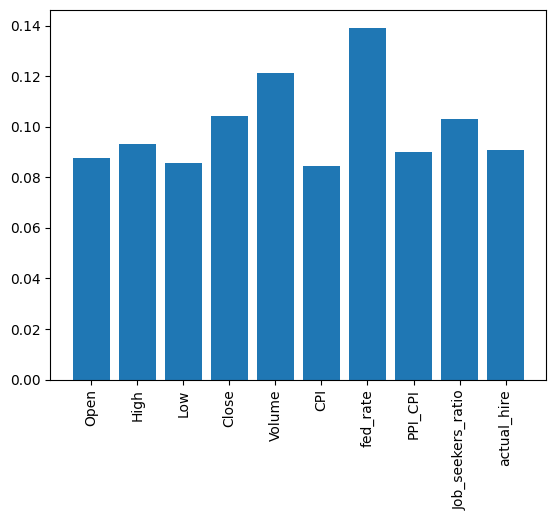

In [30]:
plt.bar(randomforestCLF.feature_names_in_,randomforestCLF.feature_importances_)
plt.xticks(rotation=90)

### Using GBoost

In [31]:
rfe_gb = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=10)
# fit the model
rfe_gb.fit(X, y)

RFE(estimator=GradientBoostingClassifier(), n_features_to_select=10)

In [32]:
rfe_gb.get_feature_names_out()

array(['Industry', 'Open', 'High', 'Low', 'Close', 'Volume', 'CPI', 'PPI',
       'job_education_health', 'fed_rate'], dtype=object)

In [33]:
gradientB_clf = Pipeline(steps = [('scaler' , StandardScaler()) , 
                                  ('gb' , GradientBoostingClassifier())])

parameters_gb = { 'gb__learning_rate' : [0.01 , 0.001 , 0.1 , 0.5 , 1] , 
                 'gb__n_estimators' : [100 , 200 , 300 , 400 , 500 , 750] , 
                 'gb__subsample' : [0.5 , 0.1 , 1.0] , 
                 'gb__criterion' : ['friedman_mse'] , 
                 'gb__max_depth' : [1 , 2 , 5 , 7 , 10 , 15] , 
                 'gb__max_features' : ['sqrt' , 'log2' , 2 , 5] , 
                 'gb__max_leaf_nodes' : [None , 2 , 3 , 5 , 6 , 7 , 8 , 9 , 10]}

gb_clf_randCV = RandomizedSearchCV(gradientB_clf , parameters_gb, n_iter=50, scoring='accuracy' , n_jobs = -1)
gb_clf_randCV.fit(X_train[rfe_gb.get_feature_names_out()] , y_train)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('gb',
                                              GradientBoostingClassifier())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'gb__criterion': ['friedman_mse'],
                                        'gb__learning_rate': [0.01, 0.001, 0.1,
                                                              0.5, 1],
                                        'gb__max_depth': [1, 2, 5, 7, 10, 15],
                                        'gb__max_features': ['sqrt', 'log2', 2,
                                                             5],
                                        'gb__max_leaf_nodes': [None, 2, 3, 5, 6,
                                                               7, 8, 9, 10],
                                        'gb__n_estimators': [100, 200, 300, 400,
                                                             500, 750],
                                        'gb__subsample': [0.5, 0.1, 1.0]},
                   scoring='accuracy')

In [34]:
gb_clf_randCV.best_params_

{'gb__subsample': 0.5,
 'gb__n_estimators': 400,
 'gb__max_leaf_nodes': None,
 'gb__max_features': 5,
 'gb__max_depth': 15,
 'gb__learning_rate': 0.01,
 'gb__criterion': 'friedman_mse'}

In [35]:
gradientB_clf = GradientBoostingClassifier(learning_rate = gb_clf_randCV.best_params_['gb__learning_rate'], 
                                                                     max_depth = gb_clf_randCV.best_params_['gb__max_depth'], 
                                                                     max_features = gb_clf_randCV.best_params_['gb__max_features'],
                                                                     max_leaf_nodes = gb_clf_randCV.best_params_['gb__max_leaf_nodes'], 
                                                                     n_estimators = gb_clf_randCV.best_params_['gb__n_estimators'],random_state=13)

gradientB_clf.fit(X_train[rfe_gb.get_feature_names_out()], y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=15, max_features=5,
                           n_estimators=400, random_state=13)

In [36]:

y_pred = gradientB_clf.predict(X_train[rfe_gb.get_feature_names_out()])
print("Train_pred:" + str(accuracy_score(y_train, y_pred)))


gb_acc, gb_f1, gb_recall, gb_pre = output_score(y_train,y_pred)


model_name.append('gb')
acc.append(gb_acc)
precision.append(gb_pre)
f1.append(gb_f1)
recall.append(gb_recall)


Train_pred:0.8712697483908719


In [37]:

y_pred_test = gradientB_clf.predict(X_test[rfe_gb.get_feature_names_out()])
print("Test_pred:" + str(accuracy_score(y_test, y_pred_test)))

gb_acc, gb_f1, gb_recall, gb_pre = output_score(y_test,y_pred_test)



acc_t.append(gb_acc)
precision_t.append(gb_pre)
f1_t.append(gb_f1)
recall_t.append(gb_recall)


print(gradientB_clf.feature_importances_)

Test_pred:0.5924914675767918
[0.05268389 0.12690752 0.12359064 0.12424622 0.12628092 0.2076218
 0.06033858 0.05788793 0.06064435 0.05979814]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Industry'),
  Text(1, 0, 'Open'),
  Text(2, 0, 'High'),
  Text(3, 0, 'Low'),
  Text(4, 0, 'Close'),
  Text(5, 0, 'Volume'),
  Text(6, 0, 'CPI'),
  Text(7, 0, 'PPI'),
  Text(8, 0, 'job_education_health'),
  Text(9, 0, 'fed_rate')])

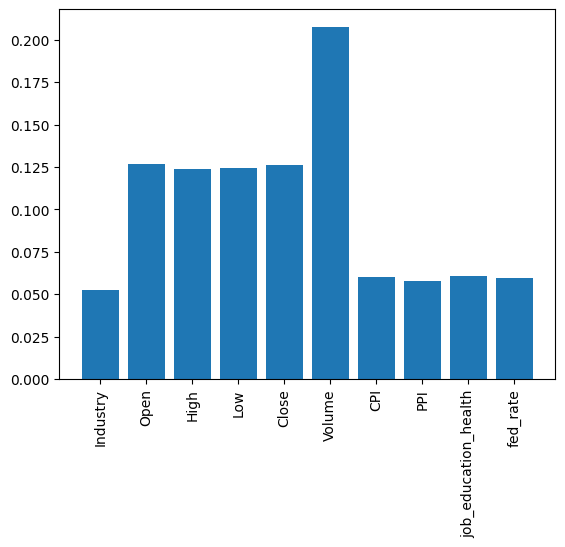

In [38]:
plt.bar(gradientB_clf.feature_names_in_,gradientB_clf.feature_importances_)
plt.xticks(rotation=90)

### Using xGBoost


In [39]:
rfe_xgb = RFE(estimator=XGBClassifier(), n_features_to_select=10)
# fit the model
rfe_xgb.fit(X, y-1)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, early_stopping_rounds=None,
                            enable_categorical=False, eval_metric=None,
                            feature_types=None, gamma=None, gpu_id=None,
                            grow_policy=None, importance_type=None,
                            interaction_constraints=None, learning_rate=None,
                            max_bin=None, max_cat_threshold=None,
                            max_cat_to_onehot=None, max_delta_step=None,
                            max_depth=None, max_leaves=None,
                            min_child_weight=None, missing=nan,
                            monotone_constraints=None, n_estimators=100,
                            n_jobs=None, num_parallel_tree=None, predictor=None,
                            random_state=None, ...),
    n_features_to_select=10)

In [40]:
rfe_xgb.get_feature_names_out()

array(['Industry', 'Volume', 'GDP', 'unemployment_rate', 'job_IT',
       'job_retail', 'job_education_health', 'fed_rate', 'PPI_chg',
       'PPI_CPI'], dtype=object)

In [41]:
from scipy import stats

param_grid = {
    'learning_rate': [0.2, 0.1],
    'num_leaves': [25, 35],
    'max_depth': [10, 12]
}

param_dist = {
    'learning_rate': stats.uniform(0.09, 0.25),
    'num_leaves': stats.randint(20,40),
    'max_depth': [10, 12]
}

param_dist_hyperopt = {
    'max_depth': 15 + hp.randint('num_leaves', 5), 
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

clf_xgb = XGBClassifier(n_estimators=150, tree_method="approx", enable_categorical=True, random_state=0, verbosity=0, n_jobs=-1)

In [42]:
# Use Shap hypertune to find xgb param

model = BoostSearch(clf_xgb, param_grid=param_grid)
model.fit(X_train[rfe_xgb.get_feature_names_out()], y_train-1, eval_set=[(X_test[rfe_xgb.get_feature_names_out()], y_test-1)], verbose=0)


8 trials detected for ('learning_rate', 'num_leaves', 'max_depth')

trial: 0001 ### iterations: 00150 ### eval_score: 1.1227
trial: 0002 ### iterations: 00150 ### eval_score: 1.18391
trial: 0003 ### iterations: 00150 ### eval_score: 1.1227
trial: 0004 ### iterations: 00150 ### eval_score: 1.18391
trial: 0005 ### iterations: 00150 ### eval_score: 1.00349
trial: 0006 ### iterations: 00150 ### eval_score: 1.04174
trial: 0007 ### iterations: 00150 ### eval_score: 1.00349
trial: 0008 ### iterations: 00150 ### eval_score: 1.04174


BoostSearch(estimator=XGBClassifier(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=150,
                                    n_jobs=-1, num_parallel_tree=None,
                                    predictor=None, random_state=0, ...),
            param_grid={'learning_rate': [0.2, 0.1], 'max_depth': [10, 12],
                        'num_leaves': [25, 35]})

In [43]:
model.estimator_, model.best_params_, model.best_score_


(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=True, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=10, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=150, n_jobs=-1, num_leaves=25,
               num_parallel_tree=None, objective='multi:softprob', ...),
 {'learning_rate': 0.1, 'num_leaves': 25, 'max_depth': 10},
 1.0034929781039674)

In [44]:
model.score(X_test[rfe_xgb.get_feature_names_out()], y_test-1)

0.5836177474402731

In [45]:
xgb_best = XGBClassifier(n_estimators=150, tree_method="approx", 
                         learning_rate = model.best_params_['learning_rate'],
                         num_leaves = model.best_params_['num_leaves'],
                         max_depth = model.best_params_['max_depth'],
                         enable_categorical=True, random_state=0, verbosity=0, n_jobs=-1)

xgb_best.fit(X_train[rfe_xgb.get_feature_names_out()],y_train-1)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=-1, num_leaves=25,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [46]:

pred = xgb_best.predict(X_train[rfe_xgb.get_feature_names_out()])

xgb_acc, xgb_f1, xgb_recall, xgb_pre = output_score(y_train-1,pred)



In [47]:
model_name.append('xgb')

acc.append(xgb_acc)
precision.append(xgb_pre)
f1.append(xgb_f1)
recall.append(xgb_recall)

In [48]:

pred = xgb_best.predict(X_test[rfe_xgb.get_feature_names_out()])

xgb_acc, xgb_f1, xgb_recall, xgb_pre = output_score(y_test-1,pred)


acc_t.append(xgb_acc)
precision_t.append(xgb_pre)
f1_t.append(xgb_f1)
recall_t.append(xgb_recall)

In [49]:
xgb_best.feature_importances_

array([0.11074574, 0.09230312, 0.07674211, 0.08795743, 0.08967483,
       0.10360028, 0.11364758, 0.12448829, 0.10153542, 0.09930515],
      dtype=float32)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Industry'),
  Text(1, 0, 'Volume'),
  Text(2, 0, 'GDP'),
  Text(3, 0, 'unemployment_rate'),
  Text(4, 0, 'job_IT'),
  Text(5, 0, 'job_retail'),
  Text(6, 0, 'job_education_health'),
  Text(7, 0, 'fed_rate'),
  Text(8, 0, 'PPI_chg'),
  Text(9, 0, 'PPI_CPI')])

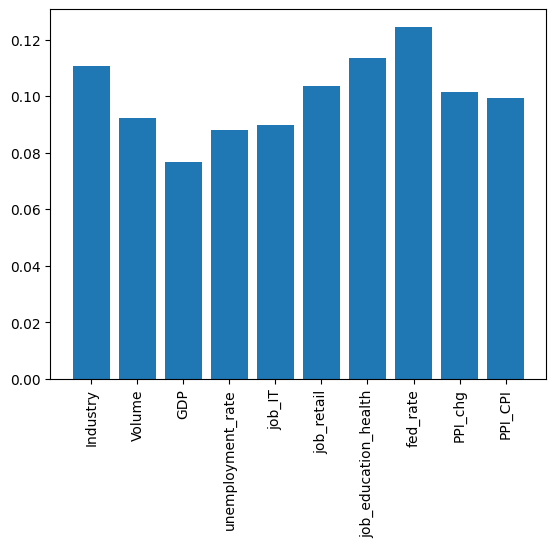

In [50]:
plt.bar(xgb_best.feature_names_in_,xgb_best.feature_importances_)
plt.xticks(rotation=90)

### <font color='orange'>Performance summary on Training set</font>

In [51]:
df_train = pd.DataFrame(data={'accuracy':acc,
                              'precision': precision,
                              'F1': f1,
                              'recall': recall},
                        index=model_name)

df_train



,accuracy,precision,F1,recall
RF,0.542715,0.360573,0.362708,0.394869
gb,0.871270,0.886576,0.858361,0.837529
xgb,0.859860,0.883476,0.841713,0.814542


### <font color='orange'>Performance summary on Test set</font>

In [52]:
df_test = pd.DataFrame(data={'accuracy':acc_t,
                              'precision': precision_t,
                              'F1': f1_t,
                              'recall': recall_t},
                        index=model_name)

df_test

,accuracy,precision,F1,recall
RF,0.556314,0.370235,0.373757,0.405538
gb,0.592491,0.523207,0.484840,0.479082
xgb,0.583618,0.505415,0.476506,0.471811
